In [3]:
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations
import IPython
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

ImportError: cannot import name 'relax' from 'tvm' (/Users/yd/Documents/tvm/python/tvm/__init__.py)

In [5]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

TypeError: Instance and class checks can only be used with @runtime_checkable protocols

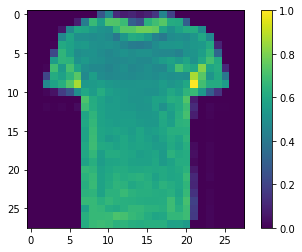

Class: T-shirt/top


In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()
print("Class:", class_names[label[0]])

In [26]:
# Hide outputs
!wget https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2022-11-23 14:27:00--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2022-11-23 14:27:01--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407396 (398K) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_params.pkl.1’

fasionmnist_mlp_par 100%[===================>] 397.85K  --.-KB/s    in 0.02s   

2022-11-23 14:27:01 (17.6 MB/s) - ‘fasionmnist_mlp_params

In [27]:
def numpy_mlp(data, w0, b0, w1, b1):
  lv0 = data @ w0.T + b0
  # relu
  lv1 = np.maximum(lv0, 0)
  lv2 = lv1 @ w1.T + b1
  return lv2

In [28]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
res = numpy_mlp(img.reshape(1, 784),
                mlp_params["w0"],
                mlp_params["b0"],
                mlp_params["w1"],
                mlp_params["b1"])
print(res)
pred_kind = res.argmax(axis=1)
print(pred_kind)
print("NumPy-MLP Prediction:", class_names[pred_kind[0]])

[[ 27.758833  -13.892406   -8.086015  -10.791249  -33.956276  -32.426804
    5.5051384 -39.881817  -18.458199  -43.687973 ]]
[0]
NumPy-MLP Prediction: T-shirt/top


In [29]:
def lnumpy_linear0(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 128), dtype="float32")
    for i in range(1):
        for j in range(128):
            for k in range(784):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(128):
            Z[i, j] = Y[i, j] + B[j]


def lnumpy_relu0(X: np.ndarray, Y: np.ndarray):
     for i in range(1):
        for j in range(128):
            Y[i, j] = np.maximum(X[i, j], 0)

def lnumpy_linear1(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 10), dtype="float32")
    for i in range(1):
        for j in range(10):
            for k in range(128):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(10):
            Z[i, j] = Y[i, j] + B[j]


def lnumpy_mlp(data, w0, b0, w1, b1):
    lv0 = np.empty((1, 128), dtype="float32")
    lnumpy_linear0(data, w0, b0, lv0)

    lv1 = np.empty((1, 128), dtype="float32")
    lnumpy_relu0(lv0, lv1)

    out = np.empty((1, 10), dtype="float32")
    lnumpy_linear1(lv1, w1, b1, out)
    return out

result =lnumpy_mlp(
    img.reshape(1, 784),
    mlp_params["w0"],
    mlp_params["b0"],
    mlp_params["w1"],
    mlp_params["b1"])

pred_kind = result.argmax(axis=1)
print("Low-level Numpy MLP Prediction:", class_names[pred_kind[0]])

Low-level Numpy MLP Prediction: T-shirt/top


In [32]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def relu0(X: T.Buffer[(1, 128), "float32"],
              Y: T.Buffer[(1, 128), "float32"]):
        # function attr dict
        T.func_attr({"global_symbol": "relu0", "tir.noalias": True})
        for i, j in T.grid(1, 128):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))

    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"],
                W: T.Buffer[(128, 784), "float32"],
                B: T.Buffer[(128,), "float32"],
                Z: T.Buffer[(1, 128), "float32"]):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @T.prim_func
    def linear1(X: T.Buffer[(1, 128), "float32"],
                W: T.Buffer[(10, 128), "float32"],
                B: T.Buffer[(10,), "float32"],
                Z: T.Buffer[(1, 10), "float32"]):
        T.func_attr({"global_symbol": "linear1", "tir.noalias": True})
        Y = T.alloc_buffer((1, 10), "float32")
        for i, j, k in T.grid(1, 10, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 10):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @R.function
    def main(x: Tensor((1, 784), "float32"),
             w0: Tensor((128, 784), "float32"),
             b0: Tensor((128,), "float32"),
             w1: Tensor((10, 128), "float32"),
             b1: Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir(relu0, (lv0,), (1, 128), dtype="float32")
            out = R.call_tir(linear1, (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out

DiagnosticError: ignored